In [ ]:
#讀取資料

In [47]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import paired_distances,cosine_similarity

In [48]:
df = pd.read_csv('./userid_like.csv')
df

,userid,id,like
0,0,1129,25
1,1,12,1
2,1,1587,193
3,2,1220,27
4,3,733,127
...,...,...,...
1670,972,69,1
1671,972,108,260
1672,973,843,5
1673,974,958,5


In [49]:
group = pd.read_csv('./recipe_group.csv')
group

,id,Cluster_category
0,1,4
1,3,0
2,4,2
3,6,3
4,7,3
...,...,...
1287,1603,1
1288,1604,1
1289,1605,4
1290,1606,3


In [50]:
df = pd.merge(df, group, how='right', on=['id'])
df 

,userid,id,like,Cluster_category
0,169,1,1,4
1,812,3,4137,0
2,442,4,260,2
3,115,6,518,3
4,366,7,1,3
...,...,...,...,...
1337,198,1603,582,1
1338,562,1604,88,1
1339,360,1605,49,4
1340,255,1606,212,3


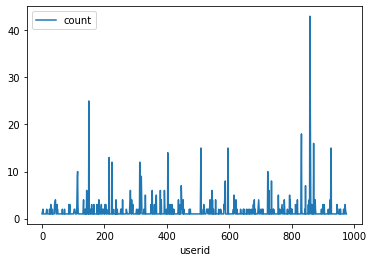

In [51]:
groups = df.groupby('userid')
pd.DataFrame(groups.size(),columns=['count']).plot();

In [52]:
# 定義find_common_id 函式，目的是找出使用者與其他使用者共同喜好的食譜

In [53]:
def find_common_receipes(user, other_users):
    s1 = set(user.id.values)
    s2 = set(other_users.id.values) 
    return s1.intersection(s2)

In [54]:
# 因為sklearn裡面的cosine_similarity是常數計算，將其改成計算向量之間的餘弦相似度

In [55]:
def vec2matrix_cosine_similarity(vec1,vec2):
    vec1 = np.mat(vec1)
    vec2 = np.mat(vec2)
    cos = float(vec1*vec2.T)/(np.linalg.norm(vec1)*np.linalg.norm(vec2))
    sim = 0.5 + 0.5 * cos
    return sim

In [56]:
# 由使用者與其他使用者共同喜好的食譜id的like去計算兩者的餘弦相似度

In [57]:
def cal_cosine_similarity_from_like(user,other_users,common_receipesId):
    user_like = user[user.id.isin(common_receipesId)].sort_values(by="id")["like"].values.reshape(1,len(common_receipesId))
    other_user_like = other_users[other_users.id.isin(common_receipesId)].sort_values(by="id")["like"].values.reshape(1,len(common_receipesId))
    sim = vec2matrix_cosine_similarity(user_like,other_user_like)
    return sim

def cal_each_user_similarity(userid):
    user_similarity = []
    for other_userid in df.userid.unique():
        if other_userid == userid:
            continue
        user = groups.get_group(userid)
        other_users = groups.get_group(other_userid)
        common_receipesId = find_common_receipes(user,other_users)
        # 避免都無關，common_receipesId = {}
        if common_receipesId != set():
            sim = cal_cosine_similarity_from_like(user,other_users,common_receipesId)
            user_similarity.append([other_userid,sim])
    return user_similarity

In [58]:
# 找出前num數量個相似的使用者Id

In [59]:
def top_num_similar_users(user_Id, num):
    user_similarity = cal_each_user_similarity(user_Id)
    user_similarity = sorted(user_similarity, key=lambda x: x[1], reverse=True)
    similar_users = [x[0] for x in user_similarity][0:num]
    return similar_users

In [60]:
# 由這些相似的使用者再找出他們評分最高的食譜作為推薦

In [63]:
def recommend(user_Id, num=10):
    # 找尋最相近的前num個使用者
    similar_users = top_num_similar_users(user_Id, num)
    # 欲搜尋的user_Id看過的食譜
    seen_receipes = df.loc[df.userid==user_Id,"id"].values
    # 由其他相似的使用者看過的食譜來找出欲搜尋的user_Id沒看過的食譜
    other_similarUsers_seen_receipes = df.loc[df.userid.isin(similar_users),"id"].values
    not_seen_receipes = set(other_similarUsers_seen_receipes)-set(seen_receipes)
    # 計算這些沒看過的食譜的平均評分
    receipe_groups = df.loc[df.id.isin(not_seen_receipes)].groupby('id')
    top_num_receipes = receipe_groups.mean().sort_values(by='like', ascending=False)[:num].index
    return df.loc[df.id.isin(top_num_receipes), "id"].unique()

In [67]:
# sort最相似的資料
searchuserid = 3
num = 1

# 透過協同過濾法推薦給searchuserid前num個食譜
recommend_top_num_receipes = recommend(searchuserid, num)

# 列出推薦名單
df_recommend_receipes = pd.DataFrame({f'推薦給[使用者{searchuserid}]的前{num}部食譜':recommend_top_num_receipes}).reset_index()
df_recommend_receipes.drop('index',axis=1,inplace=True)
df_recommend_receipes

,推薦給[使用者3]的前1部食譜
